In [14]:
from hoda_dataset_reader import read_hoda_cdb, read_hoda_dataset
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import randint, seed
from math import sqrt, ceil
import os
from PIL import Image

In [2]:
hoda_dir = "hoda-dataset/"
X_train, y_train = read_hoda_dataset(
    dataset_path=hoda_dir + "Train-60000.cdb",
    images_height=32,
    images_width=32,
    one_hot=False,
    reshape=True,
)

X_test, y_test = read_hoda_dataset(
    dataset_path=hoda_dir + "Test-20000.cdb",
    images_height=32,
    images_width=32,
    one_hot=False,
    reshape=True,
)

X_validation, y_validation = read_hoda_dataset(
    dataset_path=hoda_dir + "RemainingSamples.cdb",
    images_height=32,
    images_width=32,
    one_hot=False,
    reshape=True,
)

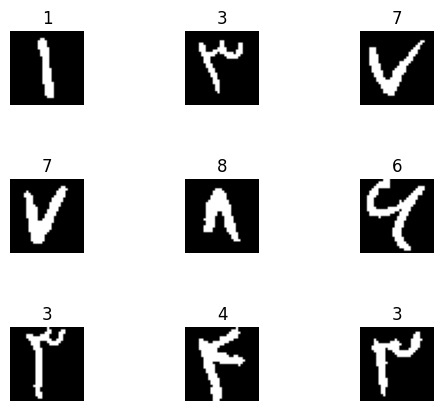

In [4]:
total = 9
row = col = ceil(sqrt(total))
fig = plt.figure()
fig.subplots_adjust(hspace=1)

for i in range(total):
    random_index = randint(0, 60000)
    fig.add_subplot(row, col, i + 1)
    plt.title(int(y_train[random_index]))
    plt.imshow(X_train[random_index].reshape([32, 32]), cmap="gray")
    plt.axis("off")

plt.show()

In [5]:
X_train[0].shape

(1024,)

In [6]:
# Normalize pixel values to be between 0 and 1
# they are aleady normalized

# Reshape the data to fit the model
X_train = X_train.reshape(-1, 32, 32, 1)
X_test = X_test.reshape(-1, 32, 32, 1)
X_validation = X_validation.reshape(-1, 32, 32, 1)

In [7]:

# Assuming your labels are integers from 0 to 9
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)  # Assuming you have 10 classes
y_validation = to_categorical(y_validation, num_classes=10)

In [8]:
# Create the model
model = Sequential()

# Add model layers
model.add(
    Conv2D(
        64, kernel_size=3, activation="relu", padding="same", input_shape=(32, 32, 1)
    )
)
model.add(Conv2D(64, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))  # Assuming you have 10 classes

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # Use 'sparse_categorical_crossentropy' if your labels are integers
    metrics=["accuracy"],
)



C:\Users\Panafor\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
print(y_test[555])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,358,986 (9.00 MB)

 Trainable params: 2,358,986 (9.00 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 227s 120ms/step - accuracy: 0.9425 - loss: 0.1862 - val_accuracy: 0.9908 - val_loss: 0.0311
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 229s 122ms/step - accuracy: 0.9893 - loss: 0.0347 - val_accuracy: 0.9935 - val_loss: 0.0229
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 219s 117ms/step - accuracy: 0.9934 - loss: 0.0209 - val_accuracy: 0.9945 - val_loss: 0.0201
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 219s 117ms/step - accuracy: 0.9952 - loss: 0.0160 - val_accuracy: 0.9945 - val_loss: 0.0196
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 228s 121ms/step - accuracy: 0.9957 - loss: 0.0147 - val_accuracy: 0.9947 - val_loss: 0.0190
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 206s 110ms/step - accuracy: 0.9963 - loss: 0.0119 - val_accuracy: 0.9954 - val_loss: 0.0162
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 208s 111ms/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.9945 - val_loss: 0.0223
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 215s 115ms/step - ac

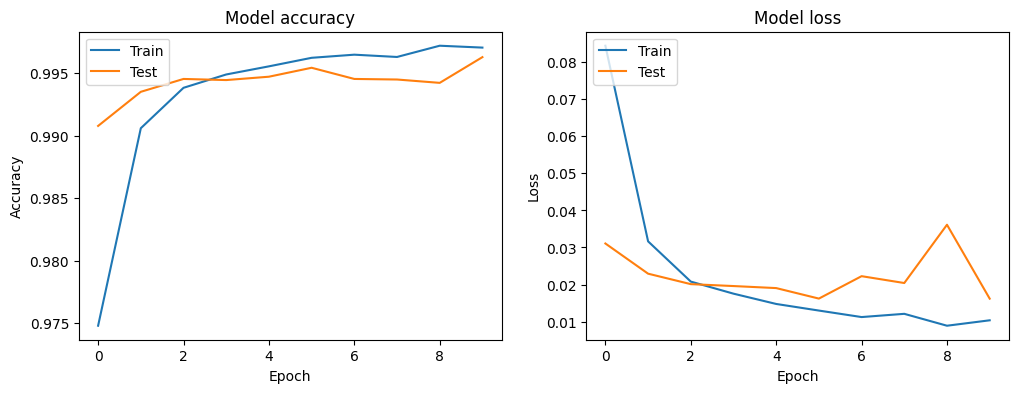

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

625/625 - 12s - 19ms/step - accuracy: 0.9956 - loss: 0.0201

Test accuracy: 0.9955999851226807

Test loss: 0.020139550790190697


In [13]:
model_dir = "models"

# Check if the model directory exists, if not create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save("models/PDRM.keras")
# PDRM => Persian Digit Recognition Model

In [53]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [60]:
from keras.models import load_model
import numpy as np
import cv2

from fastapi import FastAPI
from typing import List

model = load_model("models/model-1.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


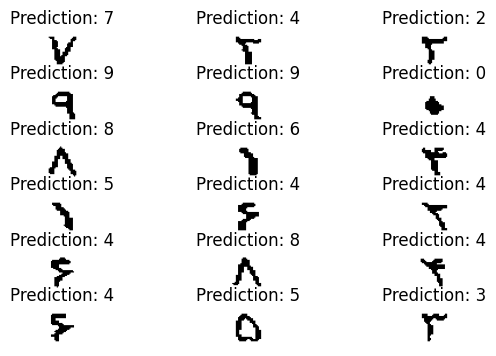

In [80]:
# Directory path
directory = "example/New folder"

directory = "example"
# Get the list of image files in the directory
image_files = [
    file
    for file in os.listdir(directory)
    if (file.endswith(".jpg") or file.endswith(".png"))
]

# Plot the images
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.5)

columns = 3
rows = len(image_files) // columns + 1
for i, file in enumerate(image_files):
    img = Image.open(os.path.join(directory, file))
    # Resize the image
    img = img.resize((32, 32))  # Adjust size as needed
    # Convert the image to grayscale if needed
    if img.mode != "L":
        img = img.convert("L")
    img_array = np.array(img)  # Convert PIL image to numpy array

    # Apply thresholding to obtain binary image
    _, digit_binary = cv2.threshold(
        img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Reshape and scale the image
    img_array = digit_binary.reshape(-1, 32, 32, 1) / 255.0
    img_array = 1 - img_array 
    # Make predictions using your model
    prediction = model.predict(img_array).argmax()

    # Plot the image
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(digit_binary, cmap="gray")
    plt.title(f"Prediction: {prediction}")
    plt.axis("off")

plt.show()

In [77]:
print(img_array)

[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]]
